In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import numpy as np
import unittest

In [17]:
class ResBlock(tf.keras.Model):
  """ A ResBlock module class with expansion, depthwise convolution and 
  projection.

  In this ResBlock, standard 2D convolutions are replaced by 1x1 convolution 
  that expands the input tensor along the channel dimension, depthwise
  convolution and 1x1 convolution that projects the tensor back to the original
  number of channels.

   Args: 
     kernel_size: size of the depthwise convolution kernel
     expansion_factor: expansion factor of the first 1x1 convolution. 
     e.g., if the input tensor has N channels, then the first 1x1 
     convolution layer will expand it to expansion_factor*N channels.
     activation: activation function. Supported functions: 'relu',
     'relu6', 'lrelu', 'swish'."""

  def __init__(self, kernel_size=3, expansion_factor=6, activation='relu'):
    super(ResBlock, self).__init__(name='')
    if expansion_factor < 1:
      raise ValueError('The expansion factor value should be '
      'greater than or equal to one.')

    self.expansion_factor = expansion_factor
    self.activation = self.set_activation_fn(activation)
    self.kernel_size = kernel_size

  def build(self, input_shape):
    input_channel = input_shape[-1]
    self.expanded_channel = input_channel*self.expansion_factor
    self.conv1 = tf.keras.layers.Conv2D(self.expanded_channel, kernel_size=1,
                                        strides=(1, 1), padding='same')
    self.bn1 = tf.keras.layers.BatchNormalization() 
    self.conv2 = tf.keras.layers.DepthwiseConv2D(kernel_size=self.kernel_size,
                                                 strides=(1, 1), padding='same')
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.conv3 = tf.keras.layers.Conv2D(input_channel, kernel_size=1,
                                        strides=(1, 1), padding='same')
    self.bn3 = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training=True):
    x = self.conv1(input_tensor)
    x = self.bn1(x, training=training)
    x = self.activation(x)

    x = self.conv2(x)
    x = self.bn2(x, training=training)
    x = self.activation(x)

    x = self.conv3(x)
    x = self.bn3(x, training=training)
    x += input_tensor
    return x


  def set_activation_fn(self, activation):
    switcher = {'relu': tf.nn.relu,
                'relu6': tf.nn.relu6,
                'lrelu': tf.nn.leaky_relu,
                'swish': tf.nn.swish}
    
    res = switcher.get(activation)
    if not res:
      raise Exception("Given activation function is not supported.")
    return res

  def _get_input_channel(self, input_shape):
    if input_shape.dims[-1].value is None:
      raise ValueError('The channel dimension of the inputs '
                       'should be defined. Found `None`.')
    return int(input_shape[-1])

# Input adapter
This model transforms the input image into tenfor of desired shape (in our setup 16x16x40).

In [18]:
def create_input_adapter(input_shape, size=16, depth=40, activation=None):
  """Creates an input adapter module for the input image.
  The input adapter transforms input image of given shape 
  into a tensor of target shape.

  Arguments: 
    input_shape: shape of input image (HxWxC). Image width and height 
      must be devidible by size. H*W*C must be less than or equal
      to size*size*depth.
    size: height and width of the output tensor after space2depth operation. 
    depth: number of channels in the output tensor.
    activation: conv layer activation function."""
  h, w, c = input_shape
  if h < size or w < size:
    raise ValueError('Input height and width should be greater than `size`.')
  # `block_size` of space2depth
  block_size = min(h / size, w / size)
  if depth % (block_size * block_size) != 0:
    raise ValueError('depth value is not devisible by the computed block size') 
  
  # creating an adapter model
  inputs = keras.Input(shape=input_shape)
  s2d = tf.nn.space_to_depth(inputs, block_size)
  outputs = layers.Conv2D(filters=depth,
                          kernel_size=1, activation=activation)(s2d)
  model = keras.Model(inputs, outputs, name='in_adapter')
  return model

# Output adapter

In [19]:
def create_output_adapter(input_shape, block_size=None, pool_stride=None,
                        activation='swish', depthwise=True):
  """ Creates an output adapter module that processes tensors before 
  passing them to fully connected layers.

  Arguments: 
    input_shape: shape of the input tensor (HxWxC).
    block_size: tensor height and width after average pooling. Default 
    value is 4.
    pool_stride: stride of average pooling.
    activation: activation function.
    depthwise: whether to use depthwise convolution."""
  if not block_size: 
    block_size = 4
  
  if not isinstance(block_size, int) or block_size < 1:
    raise ValueError("block_size must be a positive integer.")

  if pool_stride != None and (not isinstance(pool_stride, int) or
                              pool_stride < 1):
    raise ValueError("pool_stride be a positive integer or None.")
  
  if len(input_shape) != 3:
    raise ValueError("input_shape must be a tuple of size 3.")

  h, w, _ = input_shape
  inputs = keras.Input(shape=input_shape)
  kernel_size = (np.ceil(h / float(block_size)),
                 np.ceil(w / float(block_size)))

  x = tf.keras.layers.AveragePooling2D(pool_size=kernel_size, 
                                       strides=pool_stride,
                                       padding='valid')(inputs)

  if depthwise:
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=1,
                                        activation=activation)(x)
  else:
    x = tf.keras.layers.Activation(activation)(x)
  
  outputs = tf.keras.layers.Flatten(data_format='channels_last')(x)
  model = keras.Model(inputs, outputs, name='out_adapter')
  return model

# Preparing the data

In [20]:
h, w, c = (32, 32, 3)
BATCH_SIZE = 64

In [21]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [22]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                  .batch(BATCH_SIZE, drop_remainder=True)
                  .shuffle(buffer_size=50000)).repeat()
test_dataset = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                  .batch(BATCH_SIZE, drop_remainder=True)).repeat()

for image, label in test_dataset.take(1):
    print(image.shape, label.shape)

(64, 32, 32, 3) (64, 1)


In [23]:
def normalize(x, y):
  if len(x.shape) == 3:
    x = tf.expand_dims(x, axis=-1)
  x = tf.image.per_image_standardization(x)
  return x, y

def augment(x, y):
  if len(x.shape) == 3:
    x = tf.expand_dims(x, axis=-1)
  x = tf.image.resize_with_crop_or_pad(x, h + 8, w + 8)
  x = tf.image.random_crop(x, [BATCH_SIZE, h, w, c])
  x = tf.image.random_flip_left_right(x)
  x = tf.image.random_brightness(x, max_delta=0.5)
  return x, y

test_dataset = test_dataset.map(normalize)
train_dataset = (train_dataset
                 .map(augment)
                 .map(normalize))

# Creating the model

In [25]:
num_res_blocks = 10

in_adapter = create_input_adapter((h, w, c),
                                size=16, depth=40,
                                activation=tf.nn.swish)
out_adapter = create_output_adapter((16, 16, 40),
                                  block_size=1, pool_stride=None,
                                  activation=tf.nn.swish,
                                  depthwise=True)

model = tf.keras.Sequential()
model.add(in_adapter)
for _ in range(num_res_blocks):
  block = ResBlock(kernel_size=3,
                   expansion_factor=6, activation='swish')
  model.add(block)
model.add(out_adapter)
model.add(layers.Dense(256, activation=tf.nn.swish))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='softmax'))


In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in_adapter (Model)           (None, 16, 16, 40)        520       
_________________________________________________________________
res_block_30 (ResBlock)      (None, 16, 16, 40)        23960     
_________________________________________________________________
res_block_31 (ResBlock)      (None, 16, 16, 40)        23960     
_________________________________________________________________
res_block_32 (ResBlock)      (None, 16, 16, 40)        23960     
_________________________________________________________________
res_block_33 (ResBlock)      (None, 16, 16, 40)        23960     
_________________________________________________________________
res_block_34 (ResBlock)      (None, 16, 16, 40)        23960     
_________________________________________________________________
res_block_35 (ResBlock)      (None, 16, 16, 40)       

In [27]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
history = model.fit(train_dataset, epochs=30,
                    steps_per_epoch=195,
                    validation_data=test_dataset,
                    validation_steps=3)

Epoch 1/30
195/195 [==============================] - 14s 73ms/step - loss: 2.2922 - acc: 0.2440 - val_loss: 2.1017 - val_acc: 0.2031
Epoch 2/30
195/195 [==============================] - 14s 70ms/step - loss: 1.7459 - acc: 0.3485 - val_loss: 1.8901 - val_acc: 0.2656
Epoch 3/30
195/195 [==============================] - 14s 71ms/step - loss: 1.6518 - acc: 0.3817 - val_loss: 1.6862 - val_acc: 0.3229
Epoch 4/30
195/195 [==============================] - 14s 71ms/step - loss: 1.6025 - acc: 0.4084 - val_loss: 1.6154 - val_acc: 0.3750
Epoch 5/30
195/195 [==============================] - 14s 71ms/step - loss: 1.5420 - acc: 0.4301 - val_loss: 1.6334 - val_acc: 0.4271
Epoch 6/30
195/195 [==============================] - 14s 70ms/step - loss: 1.4870 - acc: 0.4503 - val_loss: 1.6717 - val_acc: 0.3906
Epoch 7/30
195/195 [==============================] - 14s 70ms/step - loss: 1.4292 - acc: 0.4748 - val_loss: 1.4059 - val_acc: 0.4740
Epoch 8/30
195/195 [==============================] - 14s 70ms

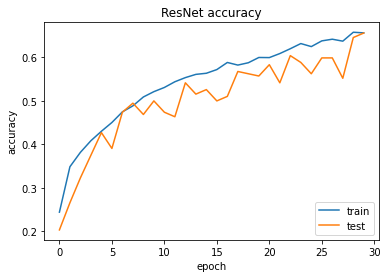

In [28]:
#Plotting the accuracy during training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('ResNet accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [29]:
results = model.evaluate(test_dataset, steps=5000)
print('test loss, test acc:', results)

5000/5000 [==============================] - 109s 22ms/step - loss: 1.1172 - acc: 0.6232
test loss, test acc: [1.1172353029251099, 0.6232343912124634]
